In [2]:
#-*- coding:utf-8 -*-
%matplotlib inline
from __future__ import division
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2 

# help function

In [1]:
def distance(list_a,list_b):
    return pow( (pow( (list_a[0] - list_b[0]),2 )+pow( (list_a[1]-list_b[1]),2 ) ),.5 )

def calcul_head_dist(input_list):
    length = len(input_list)
    for i in range(length-1):
        for j in range(i+1,length):
            dist = distance(input_list[i],input_list[j])
            if  dist <= 200:  #头部距离100像素内为真 
                #print("distance:",dist)
                if dist > 150:
                    return 1
                else:
                    return 2
    return 0

 

def load_json(json_path):
    with open(json_path) as f_json:
        data = json.load(f_json)
    return data        
    
def distance_pose(pose_a,pose_b):
    dist = 0
    joint_exist = 0
    for i in range(18):
        index = 3*i
        if pose_a[index] != 0 and pose_b[index]!=0:
            #dist = dist + abs(int(pose_a[index]) - int(pose_b[index])) + abs(int(pose_a[index+1]) - int(pose_b[index+1]))
            dist += distance(pose_a[index:index+2],pose_b[index:index+2])
            joint_exist += 1
            '''
            print("move joint:",i)
            print("add distance:",distance(pose_a[index:index+2],pose_b[index:index+2]))
            print("all dist:",dist)
            print("all joint_exist:",joint_exist)
            '''
    if joint_exist == 0:
        return 100
    else:
        return dist/joint_exist
    
def next_frame(data,last_pose):
    person_dist = {}
    for people_count in range(len(data['people'])):
        compare_pose = data['people'][people_count]['pose_keypoints_2d']
        if compare_pose.count(0) <= 45:
            dist = distance_pose(last_pose,compare_pose)
            if dist < 100:   
                person_dist[people_count] = dist
    if len(person_dist.keys()) > 0:
        target_count = min(person_dist, key=person_dist.get)
        return data["people"][target_count]
    else:
        return False         
    
def checkMiss(file_path,pose_dict):
    json_path = os.path.join(file_path,"5.walk")
    json_list = os.listdir(json_path)
    json_list.sort()
    last = int(json_list[-1].split("_")[1])
    a = []
    for i in range(last):
        a.append(i)
    return set(a).difference(pose_dict.keys())

def mean(a,b):
    tmp = [a,b]
    if tmp.count(0) == 2:
        return 0
    else:
        return (a+b)/(2-tmp.count(0))
    
def draw_frame(canvas,frame_pose,limbSeq,colors):
    color_count = 0
    for i in range(18):
        if frame_pose[3*i] != 0:
            pos = [int(frame_pose[3*i]),int(frame_pose[3*i+1])]
            cv2.circle(canvas, tuple(pos), 4, colors[i], thickness=-1)
    for bar in limbSeq:
        if int(frame_pose[3*bar[0]]) != 0 and int(frame_pose[3*bar[1]]) != 0 :
            X = np.array((int(frame_pose[3*bar[0]+1]),int(frame_pose[3*bar[1]+1])))
            Y = np.array((int(frame_pose[3*bar[0]]),int(frame_pose[3*bar[1]])))
            cur_canvas = canvas.copy()
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[color_count])
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        color_count += 1
    return canvas  


# tracking

In [3]:
#检查是否需要他人辅助，返回1 表示需要人看护，返回2 表示需要人搀扶
def checkFZ(file_path):
    json_list = os.listdir(os.path.join(file_path,"5.walk")) 
    near_flag = []
    for json_name in json_list:
        json_path = file_path+"/"+"5.walk"+"/"+json_name
        data = load_json(json_path)
        right_head = []
        for person_coord in data['people']:
            if 900<person_coord['pose_keypoints_2d'][3]:   
                right_head.append(person_coord['pose_keypoints_2d'][3:5])   #将所有图像右半部分的 关节1 加入列表
        if len(right_head) > 1:                                        #计算 关节1 之间的相互距离，距离150<dist<200为1(看护)， 
            near_flag.append(calcul_head_dist(right_head))             # dist<150为2（搀扶）
    if len(near_flag) - near_flag.count(0) > 80:                    #距离小于200的帧数大于80帧，判断为有人辅助                                       
        if near_flag.count(2)/len(near_flag) > 0.6:            #搀扶（相互接触，辅助程度高）   
            return  2  
        else:
            return  1                                          #看护（相互不接触，辅助程度低）                                 
    else: 
        return  0

def checkStart(file_path,fz_flag):
    json_list = os.listdir(os.path.join(file_path,"5.walk")) 
    json_list.sort()
    break_flag = False
    #find appear_count
    for json_name in json_list:
        json_path = file_path+"/"+"5.walk"+"/"+json_name
        data = load_json(json_path) 
        for person_coord in data['people']:
            if (900<int(person_coord['pose_keypoints_2d'][3]) <1100) and (len(person_coord['pose_keypoints_2d']) > 36):
                appear_count = int(json_name.split("_")[1]) 
                print("appear_count:",appear_count)
                break_flag = True
                break
        if break_flag == True:
            break   
    #find start_pose and start_json       
    if fz_flag == 0:
        wait_frame = 20
    else:
        wait_frame = 60
    target_count = appear_count + wait_frame
    print(target_count)
    target_json = '5.walk_' + "%012d"%(target_count) + "_keypoints.json"
    target_json_path = file_path+"/"+"5.walk"+"/"+ target_json
    data = load_json(target_json_path)
    right_person = []
    print(data)
    for person_coord in data['people']:
        if 900<int(person_coord['pose_keypoints_2d'][3])<1600:
            right_person.append(person_coord)   
    print(right_person)
    if len(right_person) == 1:
        start_pose =  right_person[0] 
    else:
        flag_foot = mean(int(right_person[0]['pose_keypoints_2d'][31]),int(right_person[0]['pose_keypoints_2d'][40]))
        for person in right_person:
            foot_mean = mean(int(person['pose_keypoints_2d'][31]),int(person['pose_keypoints_2d'][40]))
            if 900 <int(person['pose_keypoints_2d'][30]) and flag_foot <= foot_mean: 
                    flag_foot = foot_mean
                    start_pose = person
      
    '''
    img_name = "5.walk_"+"%012d"%(target_count)+"_rendered.png"
    img_path = os.path.join(file_path,"5.walk_picture",img_name)
    img_save_path = os.path.join(file_path,"pose_start.png")
    canvas = cv2.imread(img_path)
    canvas = draw_frame(canvas,start_pose['pose_keypoints_2d'],limbSeq,colors)
    cv2.imwrite(img_save_path,canvas)
    '''
    return start_pose,target_count
           
#患者跟踪 
def tracking2(file_path,start_count,start_pose):  
    json_path = os.path.join(file_path,"5.walk")
    json_list = os.listdir(json_path) 
    json_list.sort()
    pose_dict = {} 
    next_pose = start_pose['pose_keypoints_2d']
    mid_num = start_count
    last_num = int(json_list[-1].split("_")[1])
    #从中往前跟踪
    while(mid_num>0):
        mid_num = mid_num - 1
        json_name = "5.walk_" + "%012d"%(mid_num) + "_keypoints.json"
        add_path = os.path.join(json_path,json_name)
        data = load_json(add_path)
        if len(data['people'])==1:
            pose_dict[mid_num] = data['people'][0] 
            next_pose = data["people"][0]['pose_keypoints_2d']
        else:
            n_frame = next_frame(data,next_pose)
            if n_frame == False:
                mid_num = 0
            else:
                pose_dict[mid_num] = n_frame
                next_pose = n_frame['pose_keypoints_2d']
    next_pose = start_pose['pose_keypoints_2d']
    mid_num = start_count
    while(mid_num<last_num):
        mid_num = mid_num + 1
        json_name = "5.walk_" + "%012d"%(mid_num) + "_keypoints.json"
        add_path = os.path.join(json_path,json_name)
        data = load_json(add_path)
        if len(data['people'])==1:
            pose_dict[mid_num] = data['people'][0] 
            next_pose = data["people"][0]['pose_keypoints_2d']
        else:
            n_frame = next_frame(data,next_pose)
            if n_frame == False:
                mid_num = last_num
            else:
                pose_dict[mid_num] = n_frame
                next_pose = n_frame['pose_keypoints_2d']
    pose_dict[start_count] = start_pose
    return pose_dict
        
def file_process(abs_path,file_name):
    file_path = os.path.join(abs_path,file_name)
    write_name = file_name +".json"
    write_path = os.path.join(file_path,write_name)
    
    fz_flag = checkFZ(file_path)      
    if fz_flag == 1:
        print(file_name+"--它人看护，评分4分！") 
    elif fz_flag == 2:
        print(file_name+"--它人搀扶，评分4分！")   
    else:
        print(file_name+"--正常，无人辅助！")
    start_pose,start_count = checkStart(file_path,fz_flag)
    pose_dict = tracking2(file_path,start_count,start_pose)
    miss = checkMiss(file_path,pose_dict)
    print("miss:",miss)
    pose_save = {} 
    pose_save["version"] = 1.2
    pose_save["FZ"] = fz_flag
    pose_save["people"] =  pose_dict
    pose_save["miss"] = list(miss)
    with open(write_path,'w') as f_write:
        json.dump(pose_save,f_write)         
    return pose_dict

def walk_line(abs_path,file_name,pose_dict):
    save_path = os.path.join(abs_path,file_name,file_name+".png")
    head_coord = {} 
    for key in pose_dict.keys():
            head_coord[key] = pose_dict[key]['pose_keypoints_2d'][3:5]
    sorted(head_coord.keys())
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    
    max_x = 0
    
    for key in head_coord.keys():
        if max_x < head_coord[key][0]:
            x1.append(head_coord[key][0])
            y1.append(1080-head_coord[key][1])
        else:
            x2.append(head_coord[key][0])
            y2.append(1080-head_coord[key][1]+200)
        max_x = head_coord[key][0]
    plt.axis([0,1920,0,1080])      
    plt.plot(x1, y1, marker='*', ms=1,label=u'y=forward')
    plt.plot(x2, y2, marker='*', ms=1,label=u'y=backward')
    plt.xlabel(u"frame count") #X轴标签
    plt.ylabel("joint 1 coordinate of") #Y轴标签
    plt.title("A simple walk line") #标题
    plt.savefig(save_path)
    plt.show()
    '''
    head_coord_x = {}
    for key in head_coord.keys():
        head_coord_x[key] = head_coord[key][0]
    max_x =  max(head_coord_x, key=head_coord_x.get)
    print(max_x)
    for key in head_coord.keys():
        if max_x > key:
            x1.append(head_coord[key][0])
            y1.append(1080-head_coord[key][1])
        else:
            x2.append(head_coord[key][0])
            y2.append(1080-head_coord[key][1]+200)
    plt.axis([0,1920,0,1080])      
    plt.plot(x1, y1, marker='*', ms=1,label=u'y=forward')
    plt.plot(x2, y2, marker='*', ms=1,label=u'y=backward')
    plt.xlabel(u"frame count") #X轴标签
    plt.ylabel("joint 1 coordinate of") #Y轴标签
    plt.title("A simple walk line") #标题
    plt.savefig(save_path)
    plt.show()
    '''

# main

('file_name:', 'HS20180514002')
HS20180514002--正常，无人辅助！
('appear_count:', 344)
364
{u'version': 1.2, u'people': [{u'hand_right_keypoints_2d': [], u'face_keypoints_2d': [], u'hand_left_keypoints_3d': [], u'pose_keypoints_3d': [], u'pose_keypoints_2d': [277.224, 335.947, 0.814468, 291.747, 362.514, 0.94075, 268.219, 362.618, 0.896983, 250.716, 400.802, 0.616255, 283.011, 400.788, 0.341999, 315.305, 362.43, 0.912652, 315.547, 397.891, 0.821022, 271.328, 403.65, 0.695085, 274.276, 438.989, 0.837686, 291.785, 497.91, 0.787861, 294.866, 553.749, 0.801328, 309.49, 436.059, 0.833618, 315.411, 492.061, 0.798293, 339.087, 547.834, 0.728201, 271.421, 324.319, 0.768274, 286.035, 324.262, 0.791145, 271.26, 335.959, 0.300502, 294.776, 327.159, 0.787844], u'face_keypoints_3d': [], u'hand_left_keypoints_2d': [], u'hand_right_keypoints_3d': []}, {u'hand_right_keypoints_2d': [], u'face_keypoints_2d': [], u'hand_left_keypoints_3d': [], u'pose_keypoints_3d': [], u'pose_keypoints_2d': [1115.97, 200.667, 0.

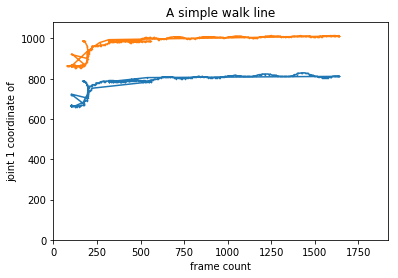

('file_name:', 'HS20180514003')
HS20180514003--正常，无人辅助！
('appear_count:', 64)
84
{u'version': 1.2, u'people': [{u'hand_right_keypoints_2d': [], u'face_keypoints_2d': [], u'hand_left_keypoints_3d': [], u'pose_keypoints_3d': [], u'pose_keypoints_2d': [1148.37, 277.233, 0.876795, 1077.69, 330.168, 0.682089, 1068.9, 335.984, 0.853619, 1080.62, 439.076, 0.833836, 1142.4, 509.685, 0.924822, 1092.45, 324.299, 0.617054, 1110.03, 433.207, 0.0651962, 1142.37, 506.655, 0.0866434, 1068.91, 530.183, 0.738465, 1048.45, 665.66, 0.766674, 951.143, 768.742, 0.826699, 1101.23, 527.281, 0.667686, 1142.39, 648.053, 0.758226, 1162.99, 789.345, 0.859965, 1142.61, 268.183, 0.936544, 0, 0, 0, 1112.99, 256.583, 0.878665, 0, 0, 0], u'face_keypoints_3d': [], u'hand_left_keypoints_2d': [], u'hand_right_keypoints_3d': []}]}
[{u'hand_right_keypoints_2d': [], u'face_keypoints_2d': [], u'hand_left_keypoints_3d': [], u'pose_keypoints_3d': [], u'pose_keypoints_2d': [1148.37, 277.233, 0.876795, 1077.69, 330.168, 0.68208

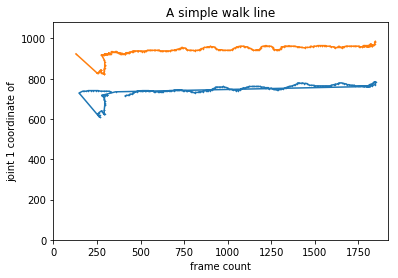

('file_name:', 'HS20180517002')
HS20180517002--正常，无人辅助！
('appear_count:', 188)
208
{u'version': 1.2, u'people': [{u'hand_right_keypoints_2d': [], u'face_keypoints_2d': [], u'hand_left_keypoints_3d': [], u'pose_keypoints_3d': [], u'pose_keypoints_2d': [350.743, 468.45, 0.380515, 315.382, 497.867, 0.883716, 338.853, 500.856, 0.829685, 338.995, 547.911, 0.771143, 362.367, 577.509, 0.645413, 291.93, 492.004, 0.867652, 271.21, 539.146, 0.259996, 271.404, 577.251, 0.0689592, 321.283, 592.067, 0.761977, 339.073, 645.036, 0.651725, 318.497, 706.9, 0.661122, 291.906, 589.193, 0.761784, 294.848, 656.821, 0.711135, 297.734, 718.658, 0.546632, 347.826, 459.725, 0.46486, 0, 0, 0, 338.92, 459.731, 0.845131, 312.458, 465.471, 0.0586457], u'face_keypoints_3d': [], u'hand_left_keypoints_2d': [], u'hand_right_keypoints_3d': []}, {u'hand_right_keypoints_2d': [], u'face_keypoints_2d': [], u'hand_left_keypoints_3d': [], u'pose_keypoints_3d': [], u'pose_keypoints_2d': [1045.44, 447.843, 0.943268, 980.605, 4

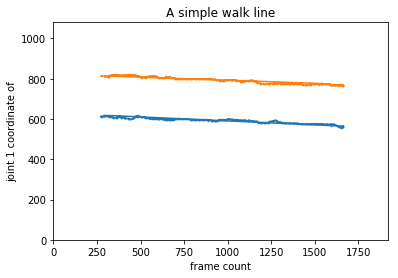

('file_name:', 'HS20180522010')
HS20180522010--正常，无人辅助！
('appear_count:', 132)
152
{u'version': 1.2, u'people': [{u'hand_right_keypoints_2d': [], u'face_keypoints_2d': [], u'hand_left_keypoints_3d': [], u'pose_keypoints_3d': [], u'pose_keypoints_2d': [135.918, 330.086, 0.410979, 129.908, 362.586, 0.911886, 100.603, 362.574, 0.842771, 68.1592, 409.637, 0.658204, 77.0114, 453.771, 0.389891, 156.594, 365.352, 0.832405, 168.291, 412.492, 0.452725, 171.227, 456.726, 0.322621, 106.494, 474.367, 0.778846, 109.354, 550.997, 0.819494, 106.52, 624.551, 0.742453, 153.426, 471.393, 0.761538, 156.514, 544.955, 0.790442, 159.446, 609.743, 0.773549, 130.097, 318.429, 0.437816, 147.587, 318.375, 0.422254, 126.941, 318.384, 0.384919, 153.479, 318.449, 0.308395], u'face_keypoints_3d': [], u'hand_left_keypoints_2d': [], u'hand_right_keypoints_3d': []}, {u'hand_right_keypoints_2d': [], u'face_keypoints_2d': [], u'hand_left_keypoints_3d': [], u'pose_keypoints_3d': [], u'pose_keypoints_2d': [1113.09, 247.84

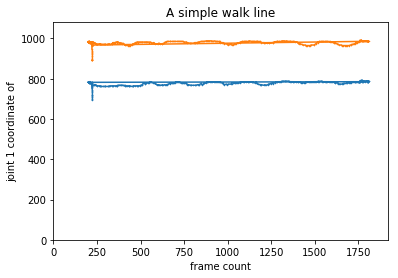

In [36]:
#### # HS20120323209,

if  __name__ == '__main__':
    abs_path = "/media/tencent/Seagate/walk_already/"
    file_name_list = os.listdir(abs_path)
    file_name_list.sort()
    for file_name in file_name_list[142:]: 
        print("file_name:",file_name)
        pose_dict = file_process(abs_path,file_name)
        walk_line(abs_path,file_name,pose_dict)
    


HS20160412001--正常，无人辅助！
('appear_count:', 214)
234
{u'version': 1.2, u'people': [{u'hand_right_keypoints_2d': [], u'face_keypoints_2d': [], u'hand_left_keypoints_3d': [], u'pose_keypoints_3d': [], u'pose_keypoints_2d': [400.761, 412.698, 0.847827, 397.794, 444.979, 0.819169, 368.407, 453.74, 0.875471, 377.196, 489.102, 0.787206, 406.601, 509.662, 0.857741, 427.291, 439.073, 0.846721, 439.157, 480.329, 0.857823, 433.222, 506.886, 0.811111, 389.167, 530.164, 0.913121, 391.896, 583.293, 0.857955, 394.926, 644.974, 0.859354, 430.13, 527.314, 0.844908, 435.988, 580.32, 0.879517, 435.963, 642.073, 0.89452, 389.157, 412.46, 0.91695, 406.556, 409.703, 0.864286, 383.117, 415.498, 0.856686, 409.502, 412.579, 0.317113], u'face_keypoints_3d': [], u'hand_left_keypoints_2d': [], u'hand_right_keypoints_3d': []}, {u'hand_right_keypoints_2d': [], u'face_keypoints_2d': [], u'hand_left_keypoints_3d': [], u'pose_keypoints_3d': [], u'pose_keypoints_2d': [206.56, 389.08, 0.555483, 174.138, 409.66, 0.85345, 

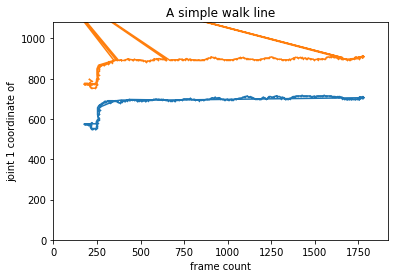

In [4]:
abs_path = "/media/tencent/Seagate/walk_already/"
file_name = 'HS20160412001'
pose_dict = file_process(abs_path,file_name)
walk_line(abs_path,file_name,pose_dict)

In [35]:
print(file_name_list.index('HS20180514002'))


142


In [45]:
d = {0:3,1:5,5:0}
d = len(d.keys())
print(d)

3


In [20]:
import os
abs_path = '/media/tencent/Seagate/walk_already/'
file_list = ['HS20120517706']
for file_name in file_list:
    json_path = os.path.join(abs_path,file_name,'5.walk')
    json_list = os.listdir(json_path)
    json_list.sort()
    if json_list[0] == "5.walk_p_000000000000_keypoints.json":
        for json_name in json_list:
            count_str = json_name.split("_")[2]
            new_name = "5.walk_"+count_str+"_keypoints.json"
            #print(os.path.join(json_path,json_name),"--",os.path.join(json_path,new_name))
            os.rename(os.path.join(json_path,json_name), os.path.join(json_path,new_name))

In [10]:
a= "5.walk_p_000000000000_keypoints.json"
b = a.split("_")[2]
new_name = "5.walk_"+b+"_keypoints.json"
print(new_name)
print(os.path.join())

5.walk_000000000000_keypoints.json


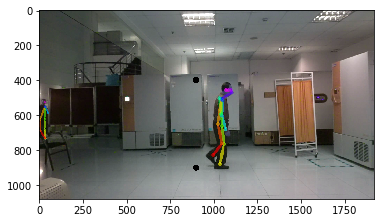

In [40]:
import cv2 
img = cv2.imread("/media/tencent/Seagate/walk_already/HS20120510691/5.walk_picture/5.walk_000000000172_rendered.png")
cv2.circle(img,tuple([900,400]), 18, [0,0,0], thickness=-1)
cv2.circle(img,tuple([900,900]), 18, [0,0,0], thickness=-1)
plt.imshow(img)
plt.show()

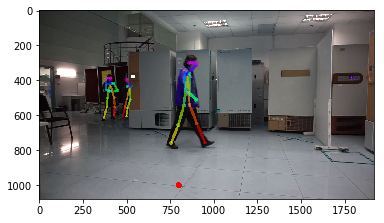

In [38]:
import cv2 
img = cv2.imread("/media/tencent/Seagate/walk_already/HS20120321113/5.walk_picture/5.walk_000000000160_rendered.png")
cv2.circle(img,tuple([800,1000]), 18, [255,0,0], thickness=-1)
plt.imshow(img)
plt.show()

In [ ]:
'''
    if fz_flag == 0:
        print(fz_flag)
        target_count = appear_count + 20
        target_json = '5.walk_' + "%012d"%(target_count) + "_keypoints.json"
        target_json_path = file_path+"/"+"5.walk"+"/"+ target_json
        data = load_json(target_json_path)
        for person_coord in data['people']:
            #print("person coord:",person_coord)
            if 900<person_coord['pose_keypoints_2d'][3]<1600:
                start_pose = person_coord['pose_keypoints_2d']
                break
    else:
        print(fz_flag)
        target_count = appear_count + 60                  #如果有人辅助，避免医生先进入的情况，使start_frame往后走60帧，保证患者在画面中
        target_json = '5.walk_' + "%012d"%(target_count) + "_keypoints.json"
        target_json_path = file_path+"/"+"5.walk"+"/" +target_json
        data = load_json(target_json_path)
        if len(data['people']) == 1:
            start_pose = data['people'][0]['pose_keypoints_2d']
            
        else:
            flag_foot = data['people'][0]['pose_keypoints_2d'][31]
            for person_coord in data['people']:
                 if 900 <person_coord['pose_keypoints_2d'][30] and flag_foot <person_coord['pose_keypoints_2d'][31]: 
                        start_pose = person_coord['pose_keypoints_2d']
                        
    return start_pose,target_count
    '''